## SENTIMEMTAL ANALYSIS USING AMAZON REVIEWS

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
!pip install streamlit
!pip install nltk

# Additional libraries for ETL and deployment
import sqlite3
import streamlit as st

# Download NLTK stopwords
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 14.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import warnings

# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

### DATA LOADING AND EXPLORATION

In [5]:
# Load the dataset
df = pd.read_csv('/content/train.csv', header=None, nrows=50000)
df.columns = ['Polarity', 'Title', 'Text']

In [6]:
# To check the columns names
print(df.columns)

Index(['Polarity', 'Title', 'Text'], dtype='object')


In [7]:
# Shape of the dataset
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (50000, 3)
   Polarity                                              Title  \
0         2                     Stuning even for the non-gamer   
1         2              The best soundtrack ever to anything.   
2         2                                           Amazing!   
3         2                               Excellent Soundtrack   
4         2  Remember, Pull Your Jaw Off The Floor After He...   

                                                Text  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...  


In [8]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

Summary Statistics:
           Polarity
count  50000.000000
mean       1.510120
std        0.499903
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000


In [9]:
# Class distribution
print("Class distribution:")
print(df['Polarity'].value_counts())

Class distribution:
Polarity
2    25506
1    24494
Name: count, dtype: int64


### DATA CLEANING

In [10]:
# Step 2: Data Initial Exploration
# Checking for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Polarity    0
Title       5
Text        0
dtype: int64


In [11]:
# Impact of Missing Data
missing_percentage = (df['Title'].isnull().sum() / len(df)) * 100
print(f"Percentage of missing values in 'Title': {missing_percentage:.2f}%")

Percentage of missing values in 'Title': 0.01%


In [12]:
# Replace with a placeholder
df['Title'] = df['Title'].fillna('No Title')

In [13]:
# Checking Title column after the cleaning for missing values
missing_title_count = df['Title'].isnull().sum()
print(f"Number of missing values in 'Title': {missing_title_count}")

Number of missing values in 'Title': 0


### DATA PREPROCESSING

In [14]:
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text using lemmatization
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatize words using spaCy
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    return text

In [15]:
# Applying the preprocessing on Text column
df['cleaned_text'] = df['Text'].apply(preprocess_text)
print("Text preprocessing complete!")

Text preprocessing complete!


### FEATURE ENGINEERING

In [16]:
# Adding additional features to get the better understanding about the data
df['Text_length'] = df['Text'].apply(len)
df['Word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
df['Avg_word_length'] = df['Text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

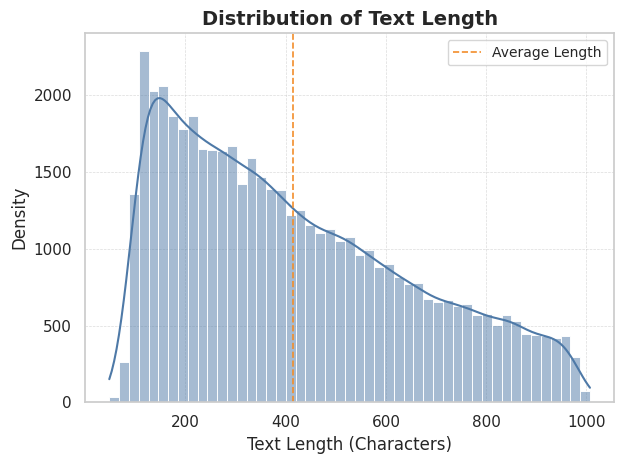

In [17]:
sns.set_theme(style="whitegrid")

# Create the histogram
sns.histplot(df['Text_length'], kde=True, color='#4E79A7')
plt.xlabel('Text Length (Characters)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axvline(df['Text_length'].mean(), color='#F28E2B', linestyle='--', linewidth=1.2, label='Average Length')
plt.legend(loc='upper right', fontsize=10)
plt.title('Distribution of Text Length', fontsize=14, fontweight='bold')
plt.tight_layout()  # Adjust layout to avoid overlaps
plt.show()

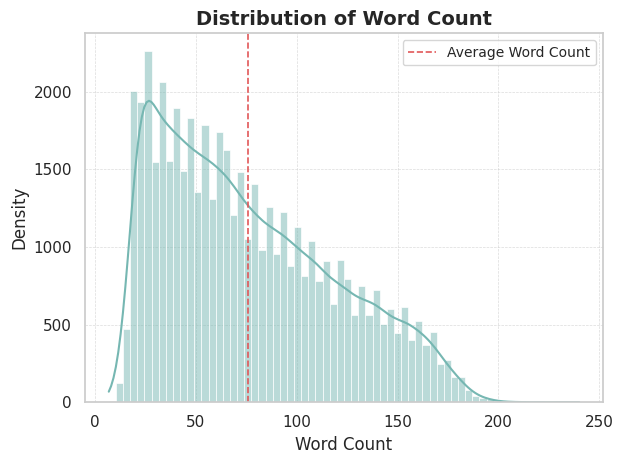

In [18]:
sns.set_theme(style="whitegrid")

# Create the histogram
sns.histplot(df['Word_count'], kde=True, color='#76B7B2')
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axvline(df['Word_count'].mean(), color='#E15759', linestyle='--', linewidth=1.2, label='Average Word Count')
plt.legend(loc='upper right', fontsize=10)
plt.title('Distribution of Word Count', fontsize=14, fontweight='bold')
plt.tight_layout()  # Adjust layout to avoid overlaps
plt.show()

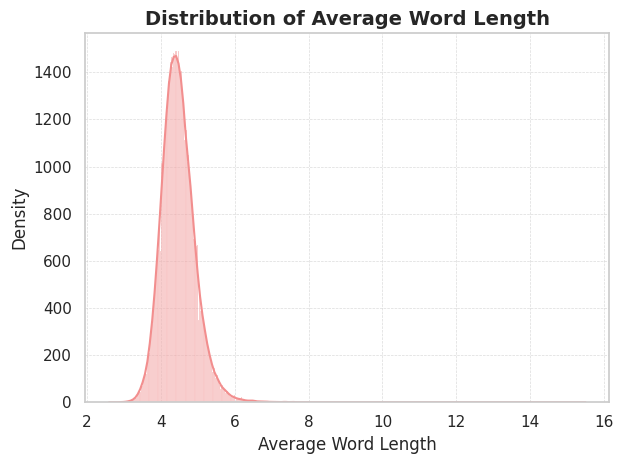

In [19]:
sns.set_theme(style="whitegrid")

# Create the histogram
sns.histplot(df['Avg_word_length'], kde=True, color='#F28E8E')
plt.xlabel('Average Word Length', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.title('Distribution of Average Word Length', fontsize=14, fontweight='bold')
plt.tight_layout()  # Adjust layout to avoid overlaps
plt.show()

### DATA INSIGHTS

In [20]:
def generate_wordcloud(input_text):
    """
    Generate and display a word cloud from the provided text.

    Parameters:
        input_text (str): The input text for generating the word cloud.
    """
    # Configure WordCloud parameters
    cloud = WordCloud(
        width=1500,
        height=800,
        max_words=500,
        background_color='black',
        colormap='coolwarm'
    )

    # Generate the word cloud
    wordcloud = cloud.generate(input_text)

    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis labels
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

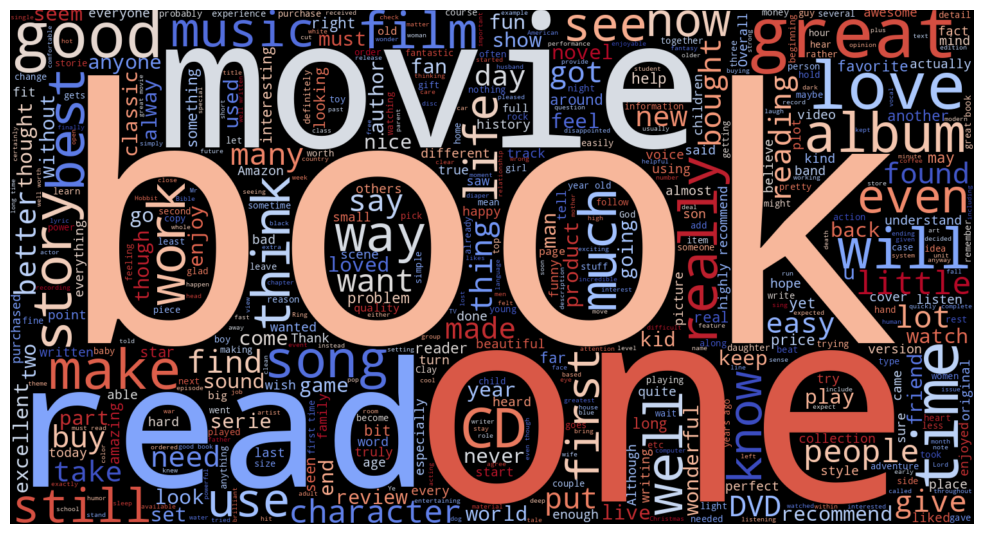

In [21]:
#wordcloud for positive reviews
positive_words = " ".join(df[df['Polarity'] == 2]['Text'])
generate_wordcloud(positive_words)

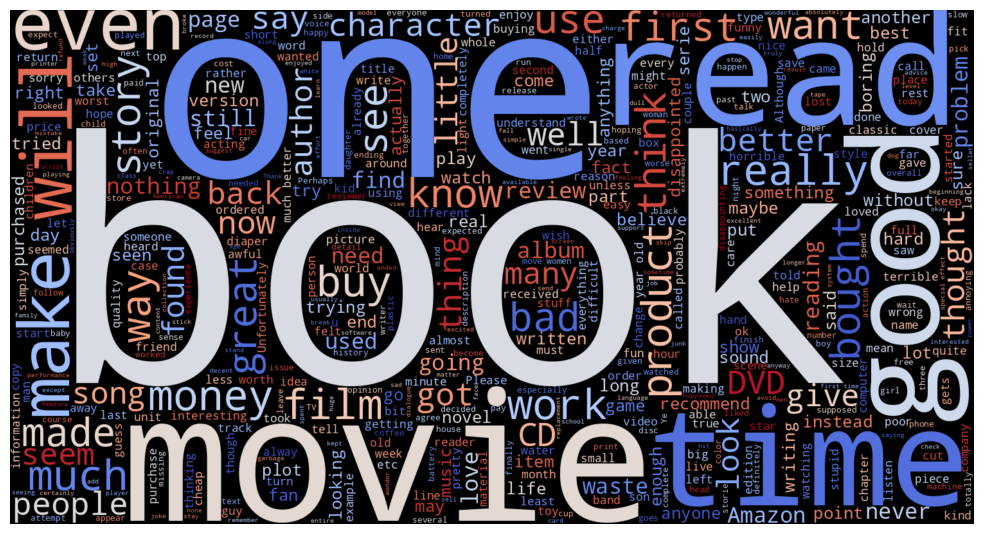

In [22]:
#wordcloud for negative reviews
negative_words = " ".join(df[df['Polarity'] == 1]['Text'])
generate_wordcloud(negative_words)

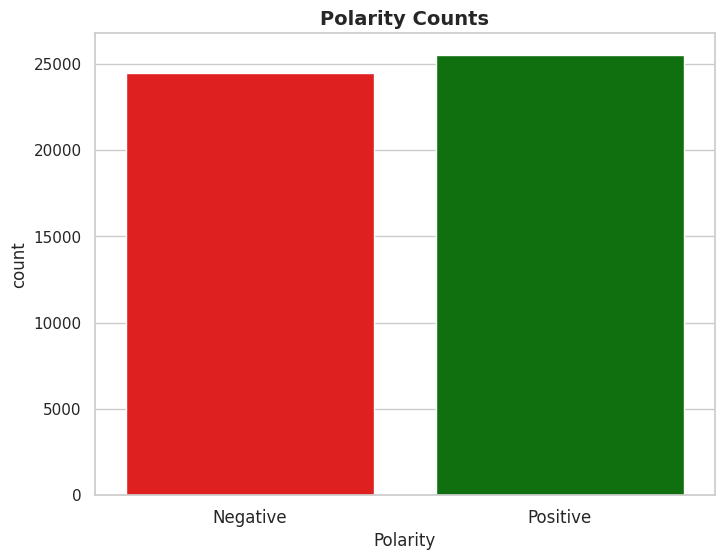

In [23]:
# Visualizing polarity distribution with custom colors and labels
plt.figure(figsize=(8, 6))

# Ensure correct category order in countplot by specifying the order explicitly
sns.countplot(x=df['Polarity'].astype(str),
              palette={'1': 'red', '2': 'green'},
              order=['1', '2'])  # Explicitly set the order of the x-ticks

# Set the title
plt.title('Polarity Counts', fontsize=14, fontweight='bold')

# Customize the x-axis labels to show 'Negative' and 'Positive'
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], fontsize=12)

# Display the plot
plt.show()

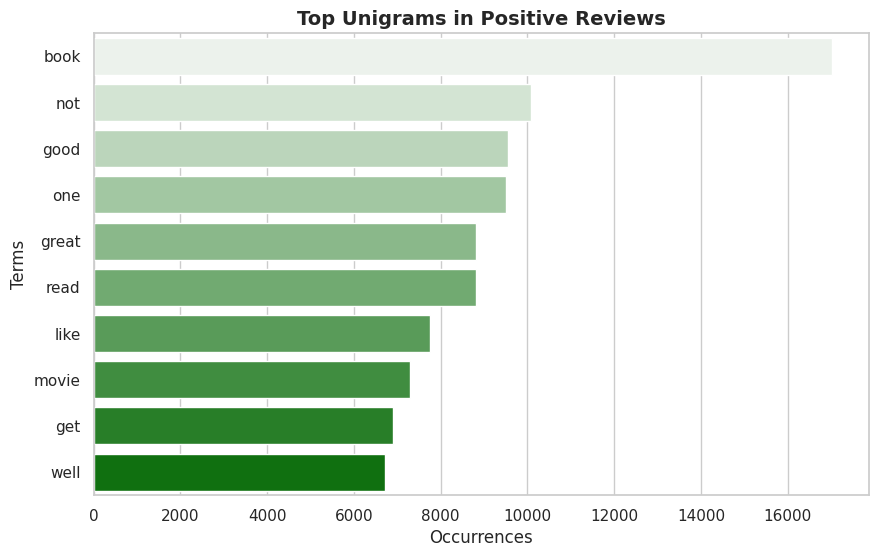

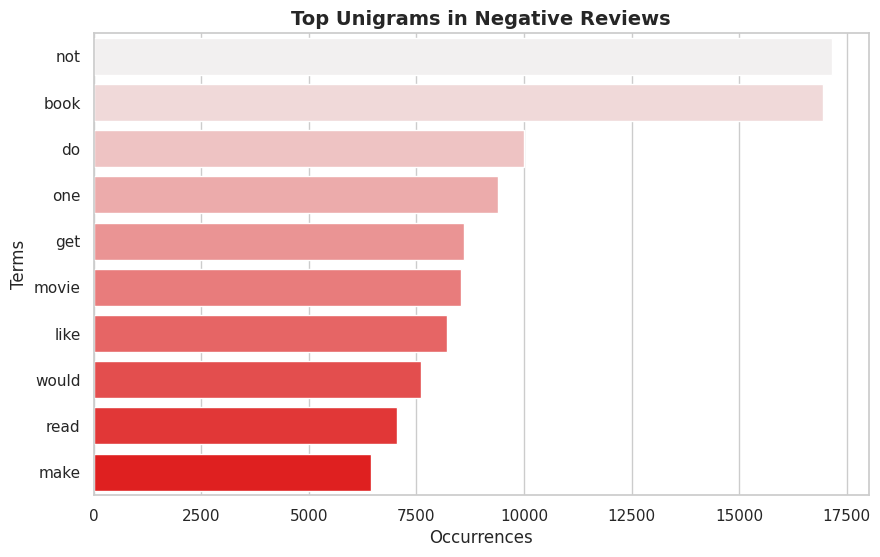

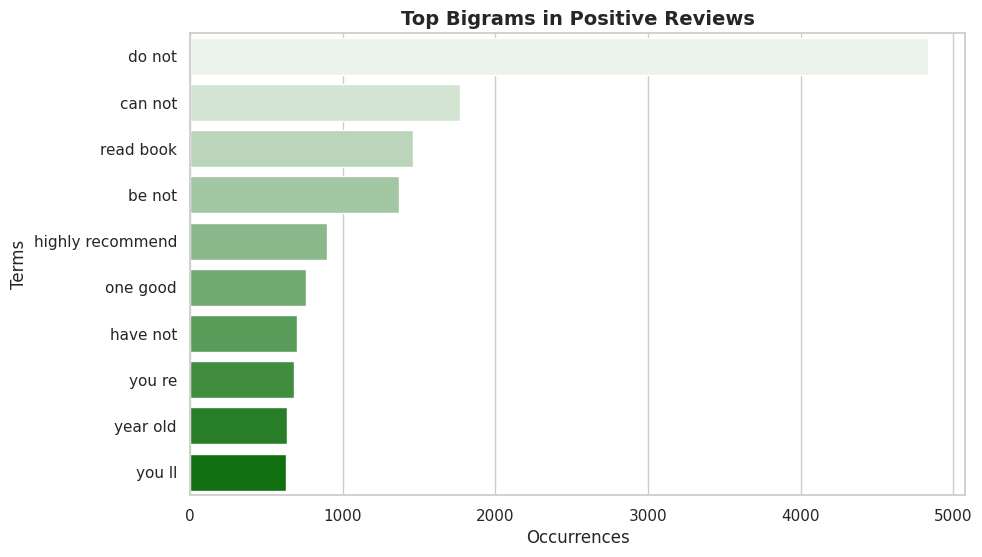

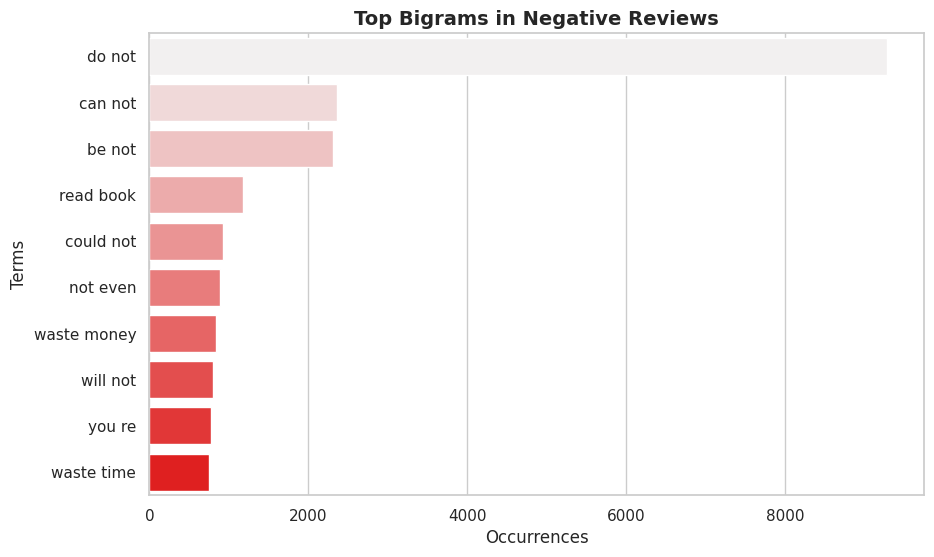

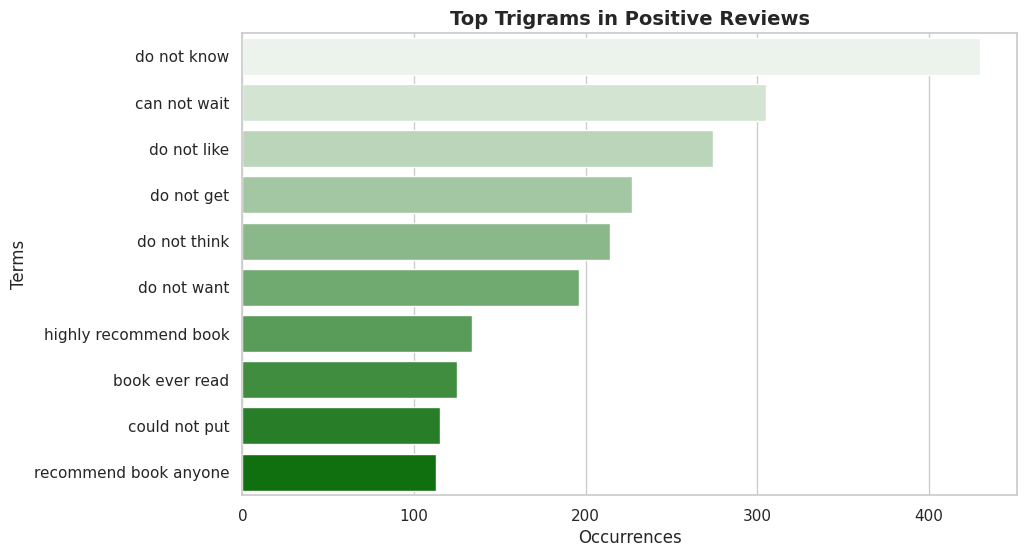

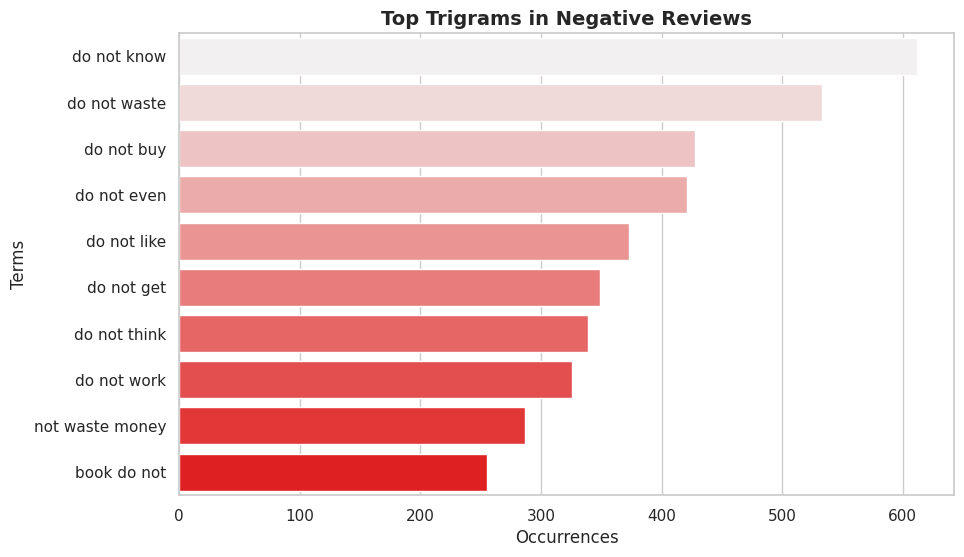

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Function to generate and display unigrams, bigrams, and trigrams individually for positive and negative reviews
def show_top_ngrams_individually(df):
    """
    Generate and display unigrams, bigrams, and trigrams individually for positive and negative reviews.

    Parameters:
        df (DataFrame): The input DataFrame containing the reviews.
    """
    # Filter reviews based on 'Polarity' (Positive: 2, Negative: 1)
    positive_reviews = df[df['Polarity'] == 2]['cleaned_text'].str.cat(sep=' ')  # Polarity 2 is Positive
    negative_reviews = df[df['Polarity'] == 1]['cleaned_text'].str.cat(sep=' ')  # Polarity 1 is Negative

    # Set up the figure for each n-gram (unigram, bigram, trigram)
    ngrams = [1, 2, 3]  # Unigrams, Bigrams, Trigrams
    ngram_names = ['Unigram', 'Bigram', 'Trigram']  # Proper names for the n-grams

    for i, n in enumerate(ngrams):
        # Create n-grams for Positive Reviews
        vectorizer = CountVectorizer(ngram_range=(n, n))
        ngram_matrix_pos = vectorizer.fit_transform([positive_reviews])
        ngram_terms_pos = vectorizer.get_feature_names_out()
        ngram_data_pos = pd.DataFrame({
            'Term': ngram_terms_pos,
            'Count': ngram_matrix_pos.toarray()[0]
        }).sort_values(by='Count', ascending=False).head(10)

        # Create a custom color palette for positive reviews: dark green to light green
        pos_palette = sns.light_palette("green", n_colors=10)

        # Plot the n-grams for Positive Reviews with a custom green color palette
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x='Count',
            y='Term',
            data=ngram_data_pos,
            palette=pos_palette
        )
        plt.title(f"Top {ngram_names[i]}s in Positive Reviews", fontsize=14, fontweight='bold')
        plt.xlabel("Occurrences", fontsize=12)
        plt.ylabel("Terms", fontsize=12)
        plt.show()

        # Create n-grams for Negative Reviews
        ngram_matrix_neg = vectorizer.fit_transform([negative_reviews])
        ngram_terms_neg = vectorizer.get_feature_names_out()
        ngram_data_neg = pd.DataFrame({
            'Term': ngram_terms_neg,
            'Count': ngram_matrix_neg.toarray()[0]
        }).sort_values(by='Count', ascending=False).head(10)

        # Create a custom color palette for negative reviews: dark red to light red
        neg_palette = sns.light_palette("red", n_colors=10)

        # Plot the n-grams for Negative Reviews with a custom red color palette
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x='Count',
            y='Term',
            data=ngram_data_neg,
            palette=neg_palette
        )
        plt.title(f"Top {ngram_names[i]}s in Negative Reviews", fontsize=14, fontweight='bold')
        plt.xlabel("Occurrences", fontsize=12)
        plt.ylabel("Terms", fontsize=12)
        plt.show()

# Example usage: Call the function to display n-grams for positive and negative reviews
show_top_ngrams_individually(df)

In [26]:
df.columns

Index(['Polarity', 'Title', 'Text', 'cleaned_text', 'Text_length',
       'Word_count', 'Avg_word_length'],
      dtype='object')

In [27]:
# Drop the unnecessary columns
df = df.drop(columns=['Title', 'Text'])

# Display the updated DataFrame
print(df.head())

   Polarity                                       cleaned_text  Text_length  \
0         2  sound track beautiful paint senery mind well w...          394   
1         2  I m read lot review say good game soundtrack f...          470   
2         2  soundtrack favorite music time hand intense sa...          750   
3         2  truly like soundtrack enjoy video game music p...          721   
4         2  you ve play game know divine music every singl...          425   

   Word_count  Avg_word_length  
0          75         4.266667  
1          91         4.175824  
2         128         4.867188  
3         116         5.224138  
4          77         4.532468  


### DATA WAREHOUSING

In [28]:
# --- Data Warehousing: Save processed data into SQLite ---
# Create a SQLite database
conn = sqlite3.connect('sentiment_analysis.db')
cursor = conn.cursor()

In [29]:
# Create a table to store processed data (if not already exists)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS reviews (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        polarity INTEGER,
        cleaned_text TEXT,
        cleaned_title TEXT,
        text_length INTEGER,
        word_count INTEGER,
        avg_word_length REAL
    )
''')

In [30]:
# Insert processed data into the table
df.to_sql('reviews', conn, if_exists='replace', index=False)

50000

In [31]:
# Verify that data is stored
cursor.execute('SELECT * FROM reviews LIMIT 5')
rows = cursor.fetchall()
print("Sample data from the warehouse:")
for row in rows:
    print(row)

Sample data from the warehouse:
(2, 'sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play good music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen', 394, 75, 4.266666666666667)
(2, 'I m read lot review say good game soundtrack figure i d write review disagree bit opinino yasunori mitsudas ultimate masterpiece music timeless I m listen year beauty simply refuse fadethe price tag pretty staggering must say go buy cd much money one feel would worth every penny', 470, 91, 4.175824175824176)
(2, 'soundtrack favorite music time hand intense sadness prisoner fate mean you ve play game hope distant promise girl steal star important inspiration personally throughout teen year high energy track like chrono cross times scar time dreamwatch chronomantique indefinably remeniscent chrono trigger absolutely superb wellthis soundtrack amazing music probably good 

In [32]:
# --- Extract Data from the Warehouse ---
query = "SELECT * FROM reviews"
df_from_db = pd.read_sql(query, conn)

In [33]:
# Close the connection
conn.close()

In [34]:
# Using df_from_db for further analysis or forecasting
print(f"Data extracted from the warehouse: {df_from_db.head()}")

Data extracted from the warehouse:    Polarity                                       cleaned_text  Text_length  \
0         2  sound track beautiful paint senery mind well w...          394   
1         2  I m read lot review say good game soundtrack f...          470   
2         2  soundtrack favorite music time hand intense sa...          750   
3         2  truly like soundtrack enjoy video game music p...          721   
4         2  you ve play game know divine music every singl...          425   

   Word_count  Avg_word_length  
0          75         4.266667  
1          91         4.175824  
2         128         4.867188  
3         116         5.224138  
4          77         4.532468  


### MODEL BUILDING

In [35]:
pip install transformers

In [39]:
# Tokenization and padding sequences for LSTM/GRU
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=200)

In [40]:
# Label Encoding for target variable (Polarity: 0=Negative, 1=Positive)
le = LabelEncoder()
y = le.fit_transform(df['Polarity'])

In [41]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### MODEL TRAINING

In [44]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=2)

Epoch 1/5
625/625 - 224s - 358ms/step - accuracy: 0.8068 - loss: 0.4219 - val_accuracy: 0.8338 - val_loss: 0.3750
Epoch 2/5
625/625 - 234s - 374ms/step - accuracy: 0.8596 - loss: 0.3345 - val_accuracy: 0.8410 - val_loss: 0.3648
Epoch 3/5
625/625 - 189s - 302ms/step - accuracy: 0.8768 - loss: 0.2981 - val_accuracy: 0.8423 - val_loss: 0.3754
Epoch 4/5
625/625 - 202s - 322ms/step - accuracy: 0.8880 - loss: 0.2738 - val_accuracy: 0.8417 - val_loss: 0.3775
Epoch 5/5
625/625 - 204s - 326ms/step - accuracy: 0.9005 - loss: 0.2450 - val_accuracy: 0.8363 - val_loss: 0.4030


### MODEL EVALUATION

In [45]:
# Evaluate the model
y_pred = (model.predict(X_test) > 0.5)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4955
           1       0.82      0.87      0.84      5045

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Accuracy: 0.8363


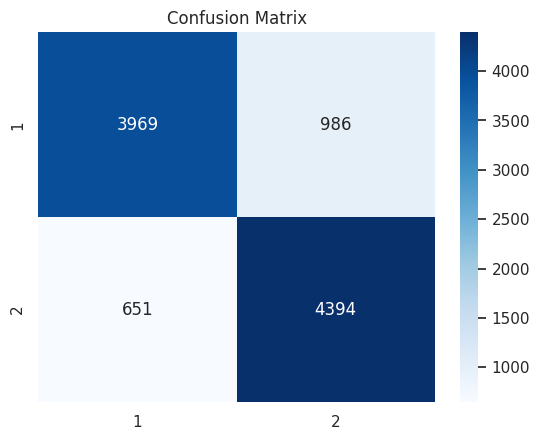

In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()

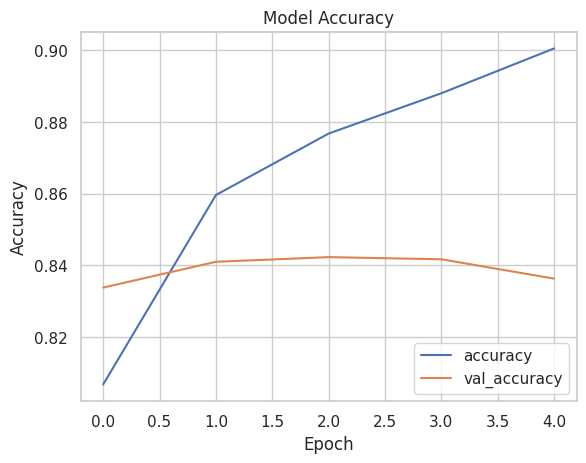

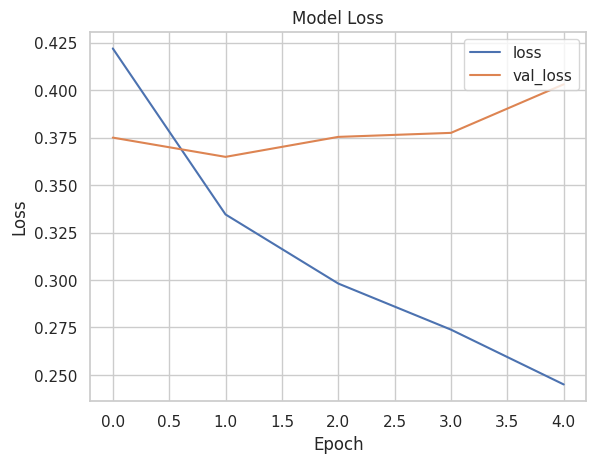

In [47]:
# Visualizing accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### SAVE THE MODEL

In [51]:
# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Save the model
model.save('sentiment_lstm_model.h5')